In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

In [2]:
OPERATION = 'addition'
assert OPERATION in ['addition', 'multiplication']



In [3]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'
full_model_name = 'EleutherAI/pythia-6.9b'
#full_model_name = 'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
remote = False
datapath = f'llm-addition/experimentation'


In [4]:
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
NLAYERS = model.config.num_hidden_layers



config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/42.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.91G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'{datapath}/data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

def get_nums_hss_solo(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].input
                    elif MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].inputs[1]['hidden_states']
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].input
                    activations.append(hs[:,-1].save())
    act = torch.stack(activations).detach().cpu()
    act = act.transpose(0, 1)
    return nums, act


In [15]:
mina = 1
maxa = 360
layer = 1
a, hss = get_nums_hss_solo( mina, maxa)
# Filter out zeros, they cannot be used with log
mask = (a != 0)
hss = hss[mask]
a = a[mask]

In [16]:
#Attempt linear fit vs full hidden state

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy())
# print("coef", model.coef_)
# print("intercept", model.intercept_)
# print("r2 score", model.score(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy()))
# print("predicted", model.predict(hss[:,layer,:].cpu().float().numpy()))
# from sklearn.metrics import r2_score
# y_true = a.cpu().float().numpy()
# y_pred = model.predict(hss[:,layer,:].cpu().float().numpy())
# r2 = r2_score(y_true, y_pred)
# print("R2 score of the model: ", r2)

# Right... this is useless as with 4096 dim hiddeen state, you can regress anything perfectly. Hence PCA. Let's try that...


In [17]:
# PCA decompose and attempt fit against each of them

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

npca = 20


hs = hss[:, layer, :].cpu().float().numpy()
scaler = StandardScaler()
hs_scaled = scaler.fit_transform(hs)

pca = PCA(n_components=npca)
tf = pca.fit_transform(hs_scaled)
# print("explained_variance_ratio", pca.explained_variance_ratio_)
# print("explained_variance", pca.explained_variance_)
# print("singular_values", pca.singular_values_)
# print("components", pca.components_)
for i in range(npca):
    lr = LinearRegression()
    x = np.log(a)[:, None]
    y = tf[:,i]
    lr.fit(x, y)
    # print("coef", i, model.coef_)
    # print("intercept", i, model.intercept_)
    print("r2 score", i, lr.score(x, y))
    # print("predicted", i, model.predict(x))



r2 score 0 0.7151400139924374
r2 score 1 0.019500780525611217
r2 score 2 0.01570806213544551
r2 score 3 0.021779702769772924
r2 score 4 0.004229641407689555
r2 score 5 0.019568234483339886
r2 score 6 0.0028055774713768855
r2 score 7 0.004569025273057359
r2 score 8 7.814434423525363e-05
r2 score 9 0.0007964063774992258
r2 score 10 1.0656469674352742e-05
r2 score 11 0.08875423188337939
r2 score 12 0.0027035267407450325
r2 score 13 0.021271691952856053
r2 score 14 0.005575243653232698
r2 score 15 0.0005959547603172632
r2 score 16 0.008729362868332924
r2 score 17 0.013296385574976477
r2 score 18 0.0007649769412969576
r2 score 19 0.0005773938338472506


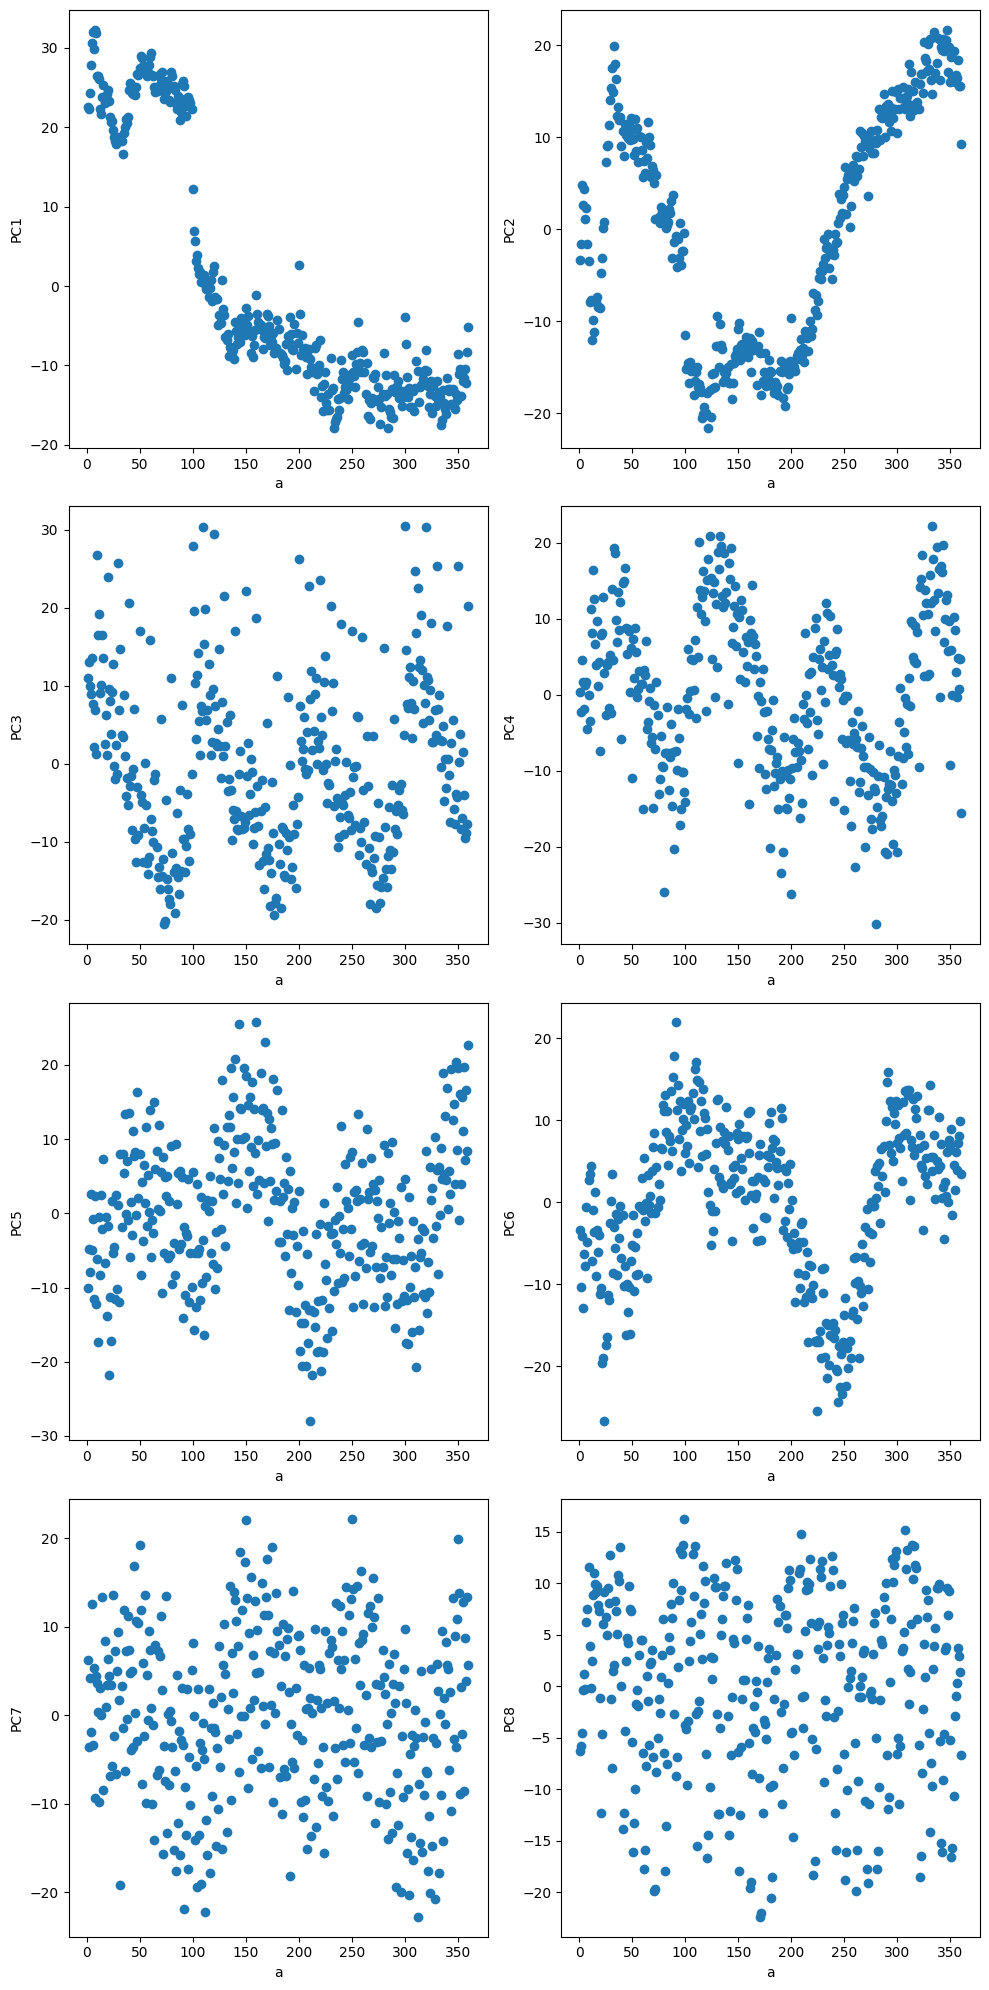

In [18]:
# Plot principal components

import matplotlib.pyplot as plt
# rng = slice(0, 105)
rng = slice(None, None)
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(a[rng], (tf[:, i][rng]))
    axs[i].set_xlabel('a')
    axs[i].set_ylabel(f'PC{i+1}')
plt.tight_layout()
plt.show()

In [99]:
a[np.abs(tf[:, 0]) > 50]

array([28., 80., 88.])

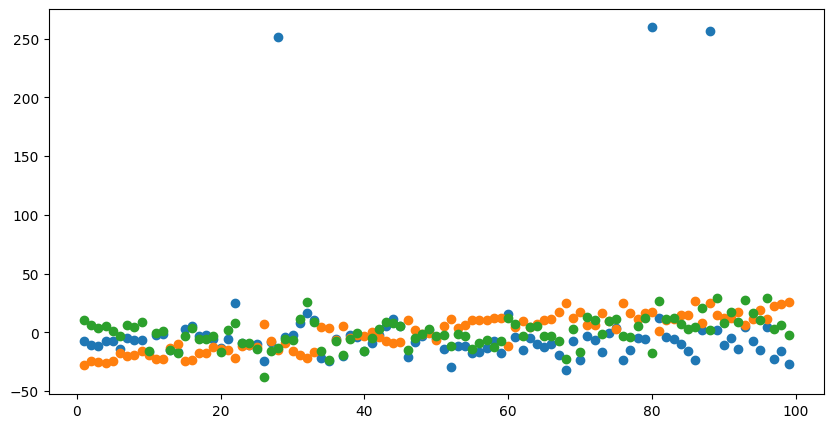

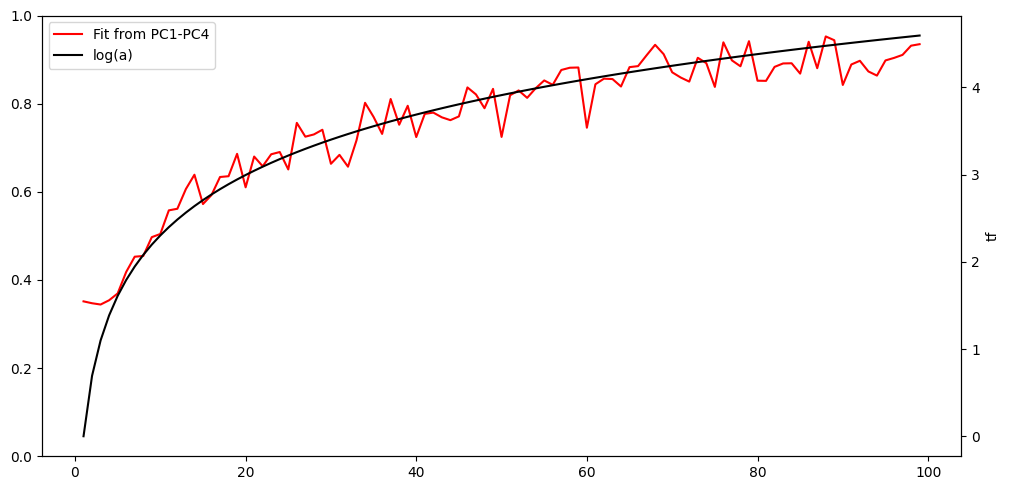

r2 score of lr: 0.9188462386657613
coefficients of lr: [ 0.00084956  0.04748451  0.00625948  0.02793448 -0.          0.00234013
  0.         -0.          0.          0.        ]


In [104]:
# Fit PC to logarithm.
# I played with components and alpha and it never plausibly recovered a fit.
components = slice(0, 10)
from sklearn.linear_model import Lasso
lr = Lasso(alpha=1)
# lr = LinearRegression()

lr.fit(tf[:, components], np.log(a))
plt.figure(figsize=(10, 5))
plt.scatter(a, tf[:, 0], label='PC1')
plt.scatter(a, tf[:, 1], label='PC2')
plt.scatter(a, tf[:, 2], label='PC3')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
# ax1.scatter(a, tf[:, 0], label='PC1')
# ax1.scatter(a, tf[:, 1], label='PC2')
ax2.plot(a, lr.predict(tf[:, components]), color='red', label='Fit from PC1-PC4')
ax2.plot(a, np.log(a), color='black', label='log(a)')
plt.tight_layout()
plt.xlabel('a')
plt.ylabel('tf')
plt.legend()
plt.show()
print("r2 score of lr:", lr.score(tf[:, components], np.log(a)))
print("coefficients of lr:", lr.coef_)



In [64]:
def check_tokenization(mina, maxa):
    "Check range of values is safe for the one-token assumption. More precise than the original paper."
    for a in range(mina, maxa+1):
        for b in range(mina, maxa+1):
            if OPERATION == "addition":
                text = f"{a}+{b}="
            else:
                text = f"{a}*{b}="
            tokens = model.tokenizer.tokenize(text)
            assert len(tokens) == 4, tokens
check_tokenization(0, 520)